# BackTapBench: Tap Detection Validation

**Purpose**: Validate and test the tap detection algorithm on 5 participants

**Input**: 5 participants × 9 grid positions = 45 CSV files

**Output**: Validated tap segments, detection statistics, parameter tuning suggestions

## 1. Setup and Configuration

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import warnings
from scipy import signal
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

# Set visual style
plt.style.use('default')
sns.set_palette("husl")

In [4]:
def get_participant_code(participant):
    num = int(participant.replace("participant", ""))
    return f"P{num:02d}"

def get_trial_filename(participant, grid_position):
    code = get_participant_code(participant)
    trial_num = grid_position + 1
    return f"{code}_trial{trial_num:04d}.csv"

def load_csv(participant, grid_position):
    filename = get_trial_filename(participant, grid_position)
    filepath = os.path.join(DATA_PATH, participant, filename)

    if not os.path.exists(filepath):
        return None, filepath

    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip()
    return df, filepath

In [5]:
# A helper to list all trials for a participant
def list_trials(participant):
    return [get_trial_filename(participant, i) for i in range(9)]

In [6]:
#TAP DETECTION PARAMETERS 
WINDOW_SIZE = 6  # rolling window for Z energy (~50ms)
Z_ENERGY_THRESHOLD = 3.0  # threshold for tap detection
GYRO_THRESHOLD = 1.0  # ignore big rotations
DEBOUNCE_MS = 120  # cooldown between taps
PRE_MS = 60  # pre-window in ms
POST_MS = 200  # post-window in ms
SAMPLING_RATE = 120  # Hz (approximate)

# Derived parameters
PRE_SAMPLES = int(PRE_MS / 1000 * SAMPLING_RATE)
POST_SAMPLES = int(POST_MS / 1000 * SAMPLING_RATE)
DEBOUNCE_SAMPLES = int(DEBOUNCE_MS / 1000 * SAMPLING_RATE)
SEGMENT_LENGTH = PRE_SAMPLES + POST_SAMPLES

print("=" * 60)
print("TAP DETECTION CONFIGURATION")
print("=" * 60)
print(f"Window size: {WINDOW_SIZE} samples ({WINDOW_SIZE*1000/SAMPLING_RATE:.0f}ms)")
print(f"Z-energy threshold: {Z_ENERGY_THRESHOLD}")
print(f"Gyro threshold: {GYRO_THRESHOLD}")
print(f"Debounce: {DEBOUNCE_MS}ms ({DEBOUNCE_SAMPLES} samples)")
print(f"Pre-tap window: {PRE_MS}ms ({PRE_SAMPLES} samples)")
print(f"Post-tap window: {POST_MS}ms ({POST_SAMPLES} samples)")
print(f"Segment length: {SEGMENT_LENGTH} samples ({SEGMENT_LENGTH*1000/SAMPLING_RATE:.0f}ms)")
print(f"Target: ~30 taps per grid position")
print("=" * 60)

TAP DETECTION CONFIGURATION
Window size: 6 samples (50ms)
Z-energy threshold: 3.0
Gyro threshold: 1.0
Debounce: 120ms (14 samples)
Pre-tap window: 60ms (7 samples)
Post-tap window: 200ms (24 samples)
Segment length: 31 samples (258ms)
Target: ~30 taps per grid position


In [7]:
DATA_PATH = r"C:\Users\jumia\Downloads\BackTap\data"
PARTICIPANTS = ["participant1", "participant2", "participant3", "participant4", "participant5"]
SENSOR_COLS = ['ax', 'ay', 'az', 'highX', 'highY', 'highZ', 'accelMag', 'gx', 'gy', 'gz']

## 2. Tap Detection Algorithm

In [9]:
def detect_taps_in_signal(highZ, gyro_mag, window_size=WINDOW_SIZE, 
                          z_threshold=Z_ENERGY_THRESHOLD, 
                          gyro_threshold=GYRO_THRESHOLD,
                          debounce_samples=DEBOUNCE_SAMPLES):
    """
    Detect tap positions using Z-energy algorithm
    Returns: list of tap center indices
    """
    n = len(highZ)
    energy_window = deque(maxlen=window_size)
    tap_indices = []
    last_tap_idx = -debounce_samples  # Start with negative to allow first tap
    
    for i in range(n):
        energy_window.append(highZ[i])
        
        # Wait until window is full
        if len(energy_window) < window_size:
            continue
            
        # Calculate Z-energy
        energyZ = np.mean(np.array(energy_window)**2)
        
        # Check tap conditions
        if (energyZ > z_threshold and 
            gyro_mag[i] < gyro_threshold and 
            (i - last_tap_idx) > debounce_samples):
            
            tap_indices.append(i)
            last_tap_idx = i
    
    return tap_indices

def extract_tap_segments(df, tap_indices, pre_samples=PRE_SAMPLES, 
                         post_samples=POST_SAMPLES, sensor_cols=SENSOR_COLS):
    """
    Extract segments around detected tap positions
    Returns: list of segment arrays
    """
    segments = []
    n = len(df)
    
    for tap_center in tap_indices:
        start_idx = max(0, tap_center - pre_samples)
        end_idx = min(n, tap_center + post_samples)
        
        # Extract sensor data
        segment = df.iloc[start_idx:end_idx][sensor_cols].to_numpy()
        
        # Pad if necessary to consistent length
        target_length = pre_samples + post_samples
        if len(segment) < target_length:
            pad_before = pre_samples - (tap_center - start_idx)
            pad_after = post_samples - (end_idx - tap_center)
            segment = np.pad(segment, 
                            ((pad_before, pad_after), (0, 0)), 
                            mode='edge')
        
        segments.append(segment)
    
    return segments

## 3. Single File Validation

In [11]:
def validate_single_file(participant, grid_position, visualize=True):
    """
    Validate tap detection on a single file
    """

    # Load using your centralized helper
    df, filepath = load_csv(participant, grid_position)

    if df is None:
        print(f"❌ File not found: {filepath}")
        return None, None, None

    filename = os.path.basename(filepath)

    print(f"📄 Loaded: {filepath}")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")

    # Gyroscope magnitude
    gyro_mag = np.sqrt(df["gx"]**2 + df["gy"]**2 + df["gz"]**2)

    # Tap detection
    tap_indices = detect_taps_in_signal(df["highZ"].values, gyro_mag)

    # Extract tap segments
    segments = extract_tap_segments(df, tap_indices)

    # Summary
    print(f"📊 {participant} - Grid {grid_position} ({filename}):")
    print(f"   Samples: {len(df):,}")
    print(f"   Duration: {len(df) / SAMPLING_RATE:.1f}s")
    print(f"   Detected taps: {len(tap_indices)}")
    print(f"   Expected: ~30 taps")

    # Optional visualization
    if visualize and len(tap_indices) > 0:
        visualize_tap_detection(
            df,
            tap_indices,
            gyro_mag,
            f"{participant} - Grid {grid_position}"
        )

    return df, tap_indices, segments

In [12]:
def visualize_tap_detection(df, tap_indices, gyro_mag, title):
    """
    Visualize tap detection results
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 8))
    fig.suptitle(title, fontsize=14, y=1.02)
    
    # Plot 1: HighZ with detected taps
    axes[0].plot(df['highZ'].values, color='green', alpha=0.7, label='highZ')
    axes[0].axhline(y=Z_ENERGY_THRESHOLD, color='r', linestyle='--', 
                   alpha=0.5, label=f'Threshold ({Z_ENERGY_THRESHOLD})')
    
    # Mark detected taps
    for tap_idx in tap_indices:
        axes[0].axvline(x=tap_idx, color='blue', linestyle=':', alpha=0.3)
    
    axes[0].set_ylabel('High-Z')
    axes[0].set_xlabel('Samples')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title(f'HighZ Signal with {len(tap_indices)} Detected Taps')
    
    # Plot 2: Z-energy (smoothed)
    window = np.ones(WINDOW_SIZE) / WINDOW_SIZE
    z_energy = np.convolve(df['highZ'].values**2, window, mode='same')
    axes[1].plot(z_energy, color='orange', alpha=0.7, label='Z-energy')
    axes[1].axhline(y=Z_ENERGY_THRESHOLD, color='r', linestyle='--', alpha=0.5)
    axes[1].set_ylabel('Z-energy')
    axes[1].set_xlabel('Samples')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_title(f'Z-energy (window={WINDOW_SIZE})')
    
    # Plot 3: Gyro magnitude
    axes[2].plot(gyro_mag, color='purple', alpha=0.7, label='Gyro Magnitude')
    axes[2].axhline(y=GYRO_THRESHOLD, color='r', linestyle='--', 
                   alpha=0.5, label=f'Threshold ({GYRO_THRESHOLD})')
    axes[2].set_ylabel('Gyro Magnitude')
    axes[2].set_xlabel('Samples')
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_title('Gyroscope Magnitude (tap rejected if above threshold)')
    
    plt.tight_layout()
    plt.show()
    
    # Show a few tap segments
    if len(tap_indices) > 0:
        show_sample_segments(df, tap_indices)

In [13]:
def show_sample_segments(df, tap_indices, num_segments=3):
    """
    Show sample tap segments
    """
    fig, axes = plt.subplots(num_segments, 3, figsize=(15, 3*num_segments))
    
    for i in range(min(num_segments, len(tap_indices))):
        tap_idx = tap_indices[i]
        start_idx = max(0, tap_idx - PRE_SAMPLES)
        end_idx = min(len(df), tap_idx + POST_SAMPLES)
        
        # Plot accelerometer
        axes[i, 0].plot(df['ax'].values[start_idx:end_idx], label='ax', alpha=0.7)
        axes[i, 0].plot(df['ay'].values[start_idx:end_idx], label='ay', alpha=0.7)
        axes[i, 0].plot(df['az'].values[start_idx:end_idx], label='az', alpha=0.7)
        axes[i, 0].axvline(x=PRE_SAMPLES, color='r', linestyle='--', label='Tap Center')
        axes[i, 0].set_title(f'Tap {i+1}: Accelerometer')
        axes[i, 0].set_ylabel('Acceleration')
        axes[i, 0].legend(loc='upper right')
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot high-frequency
        axes[i, 1].plot(df['highX'].values[start_idx:end_idx], label='highX', alpha=0.7)
        axes[i, 1].plot(df['highY'].values[start_idx:end_idx], label='highY', alpha=0.3)
        axes[i, 1].plot(df['highZ'].values[start_idx:end_idx], label='highZ', alpha=0.7, linewidth=2)
        axes[i, 1].axvline(x=PRE_SAMPLES, color='r', linestyle='--')
        axes[i, 1].set_title(f'Tap {i+1}: High-Freq')
        axes[i, 1].set_ylabel('High-Freq')
        axes[i, 1].legend(loc='upper right')
        axes[i, 1].grid(True, alpha=0.3)
        
        # Plot gyroscope
        axes[i, 2].plot(df['gx'].values[start_idx:end_idx], label='gx', alpha=0.7)
        axes[i, 2].plot(df['gy'].values[start_idx:end_idx], label='gy', alpha=0.7)
        axes[i, 2].plot(df['gz'].values[start_idx:end_idx], label='gz', alpha=0.7)
        axes[i, 2].axvline(x=PRE_SAMPLES, color='r', linestyle='--')
        axes[i, 2].set_title(f'Tap {i+1}: Gyroscope')
        axes[i, 2].set_ylabel('Angular Velocity')
        axes[i, 2].legend(loc='upper right')
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.suptitle(f'Sample Tap Segments (Length: {SEGMENT_LENGTH} samples)', y=1.02)
    plt.tight_layout()
    plt.show()

## 4. Test on Sample Files

TESTING TAP DETECTION ON SAMPLE FILES
📄 Loaded: C:\Users\jumia\Downloads\BackTap\data\participant1\P01_trial0001.csv
   Shape: (3994, 11)
   Columns: ['timestamp', 'ax', 'ay', 'az', 'highX', 'highY', 'highZ', 'accelMag', 'gx', 'gy', 'gz']
📊 participant1 - Grid 0 (P01_trial0001.csv):
   Samples: 3,994
   Duration: 33.3s
   Detected taps: 29
   Expected: ~30 taps


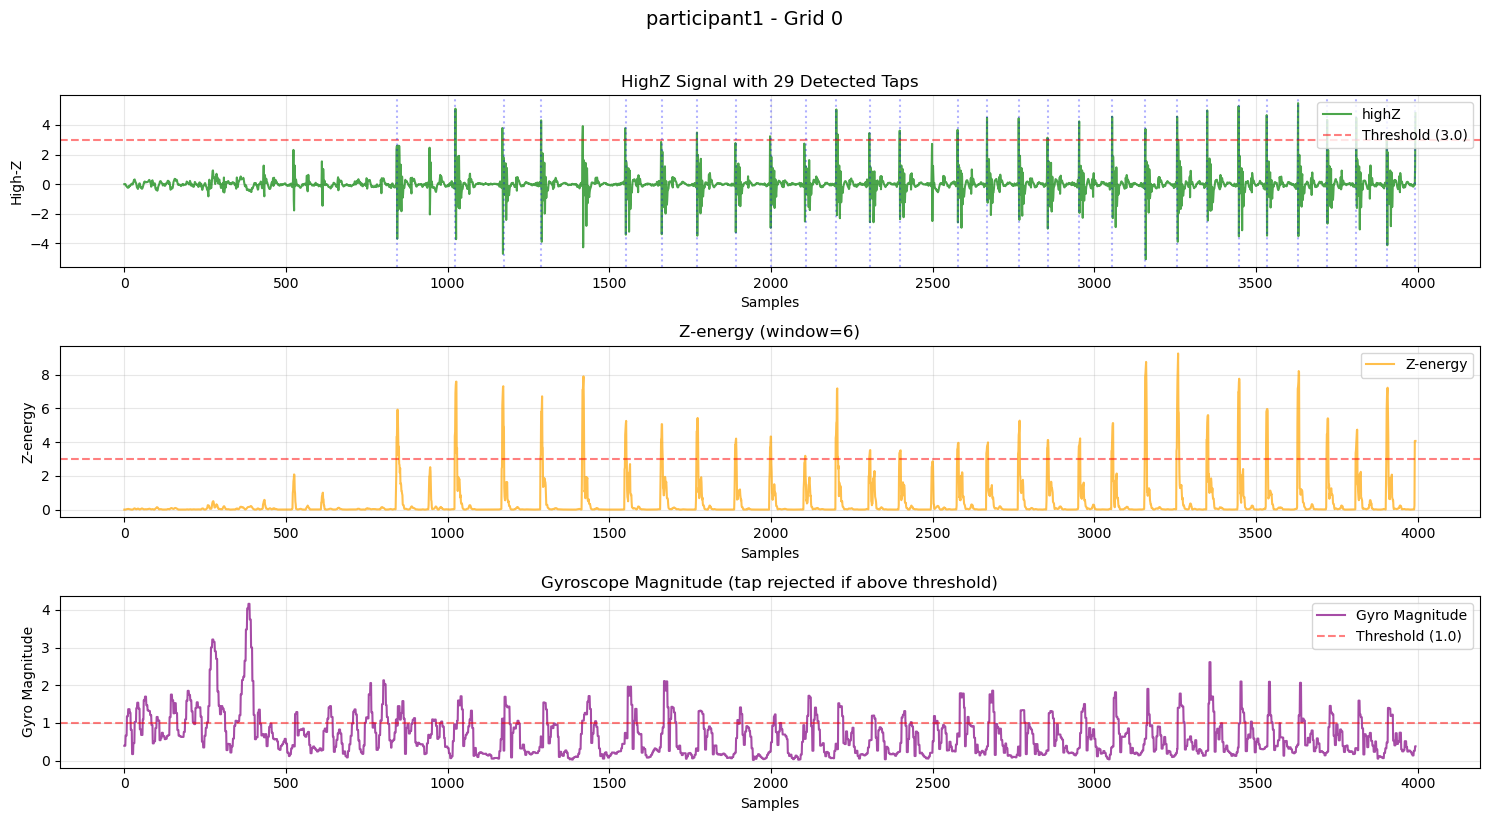

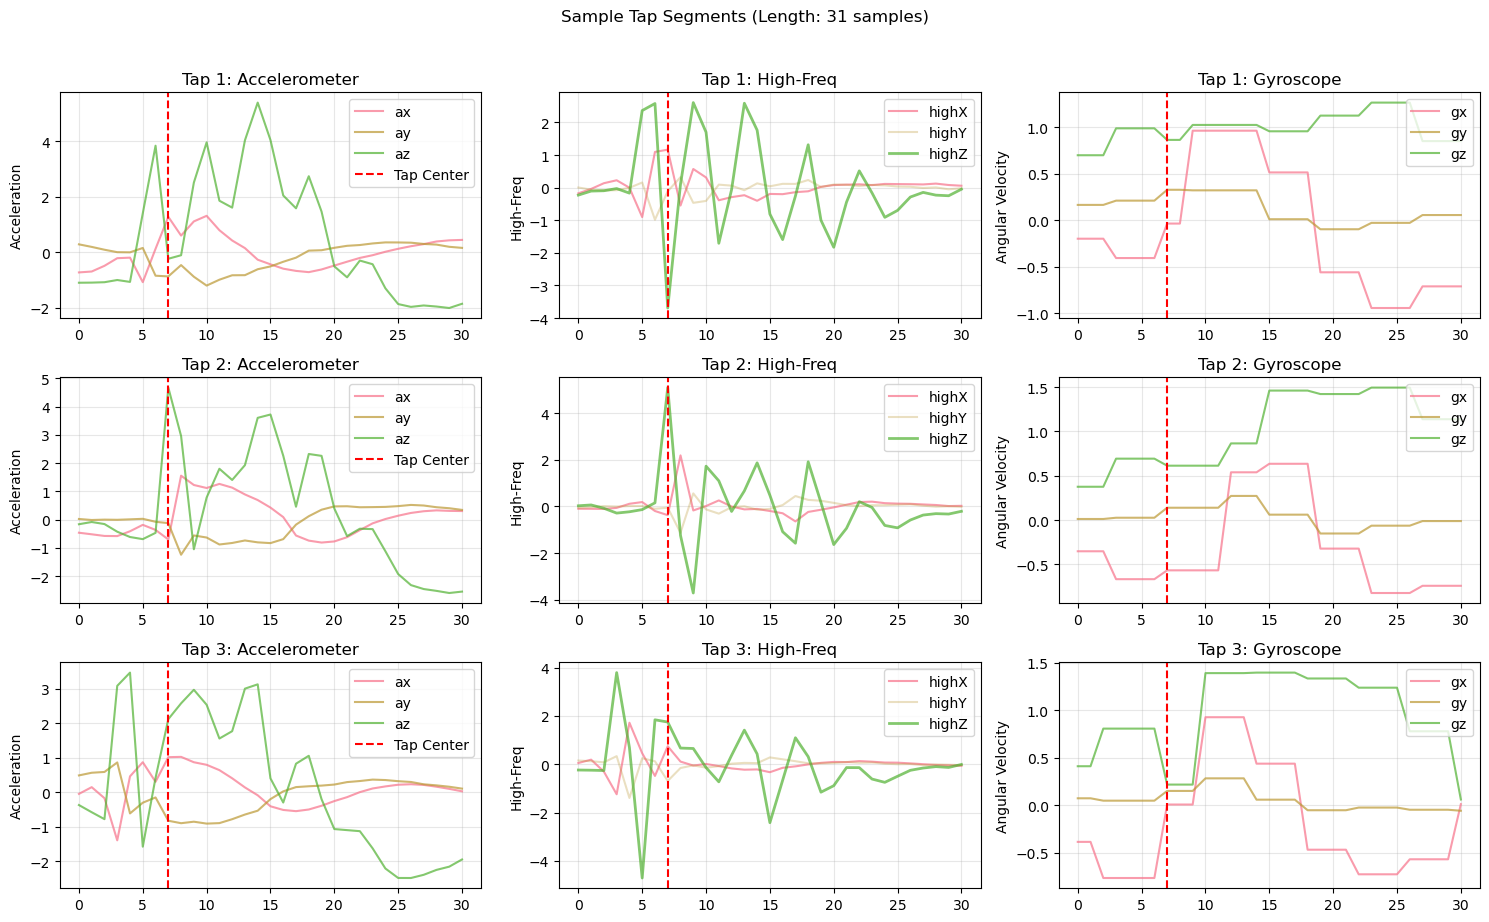


📄 Loaded: C:\Users\jumia\Downloads\BackTap\data\participant1\P01_trial0005.csv
   Shape: (8538, 11)
   Columns: ['timestamp', 'ax', 'ay', 'az', 'highX', 'highY', 'highZ', 'accelMag', 'gx', 'gy', 'gz']
📊 participant1 - Grid 4 (P01_trial0005.csv):
   Samples: 8,538
   Duration: 71.2s
   Detected taps: 23
   Expected: ~30 taps


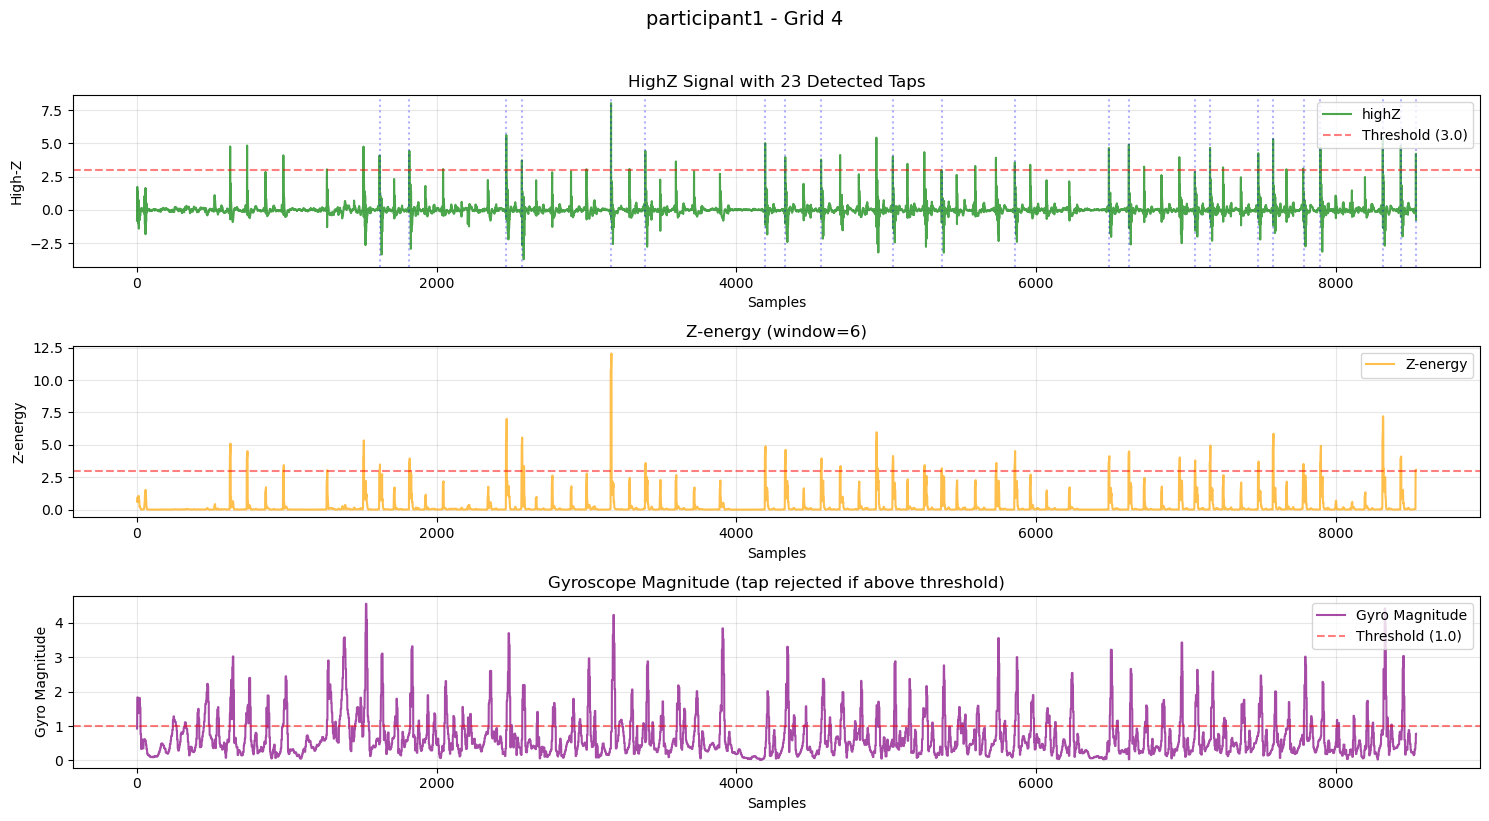

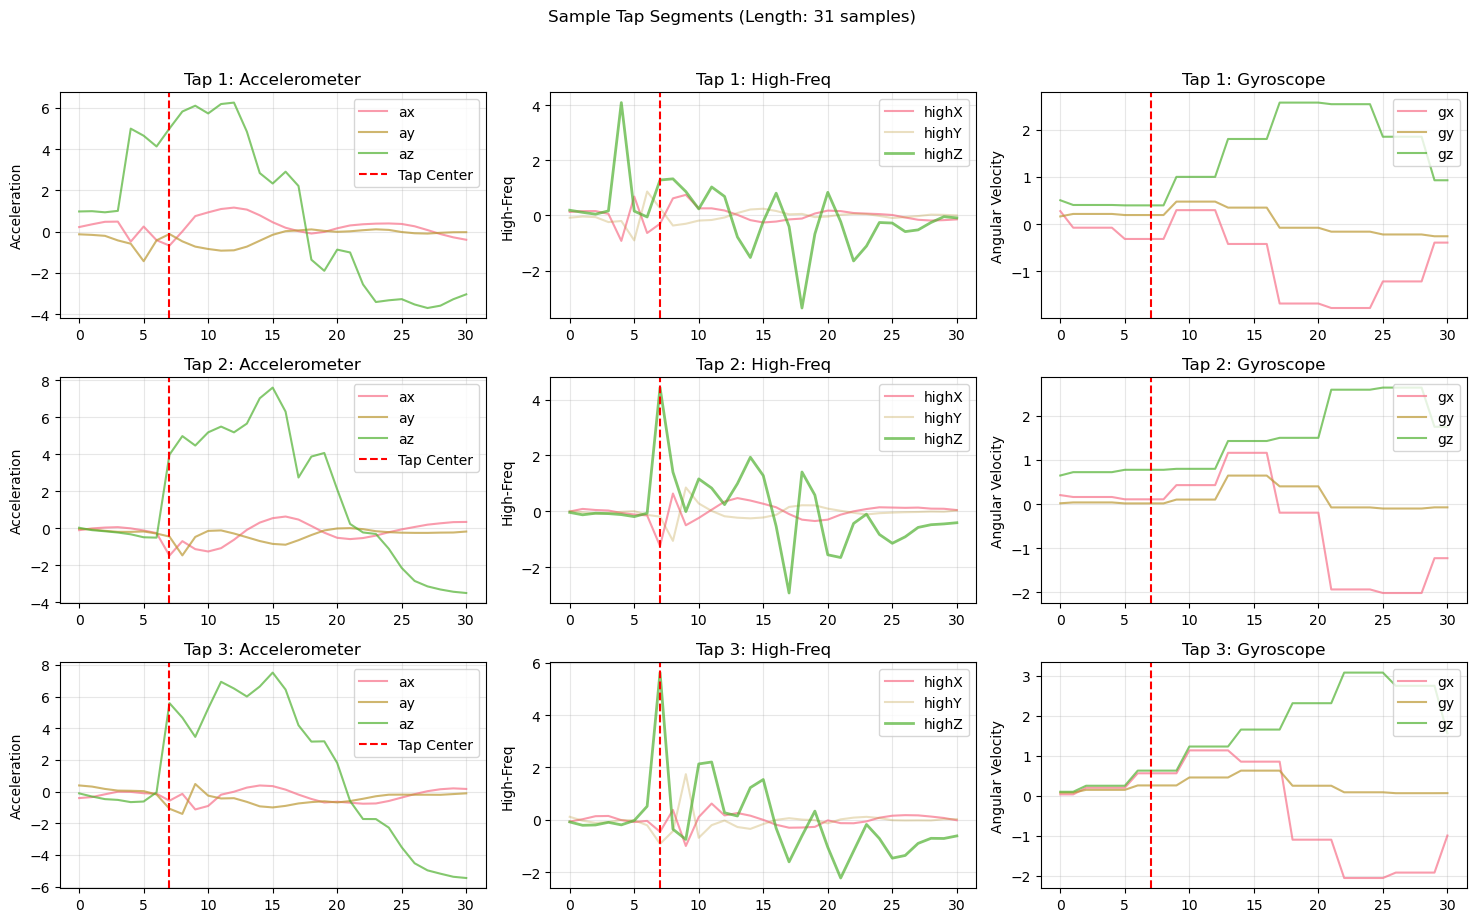


📄 Loaded: C:\Users\jumia\Downloads\BackTap\data\participant1\P01_trial0009.csv
   Shape: (12302, 11)
   Columns: ['timestamp', 'ax', 'ay', 'az', 'highX', 'highY', 'highZ', 'accelMag', 'gx', 'gy', 'gz']
📊 participant1 - Grid 8 (P01_trial0009.csv):
   Samples: 12,302
   Duration: 102.5s
   Detected taps: 28
   Expected: ~30 taps


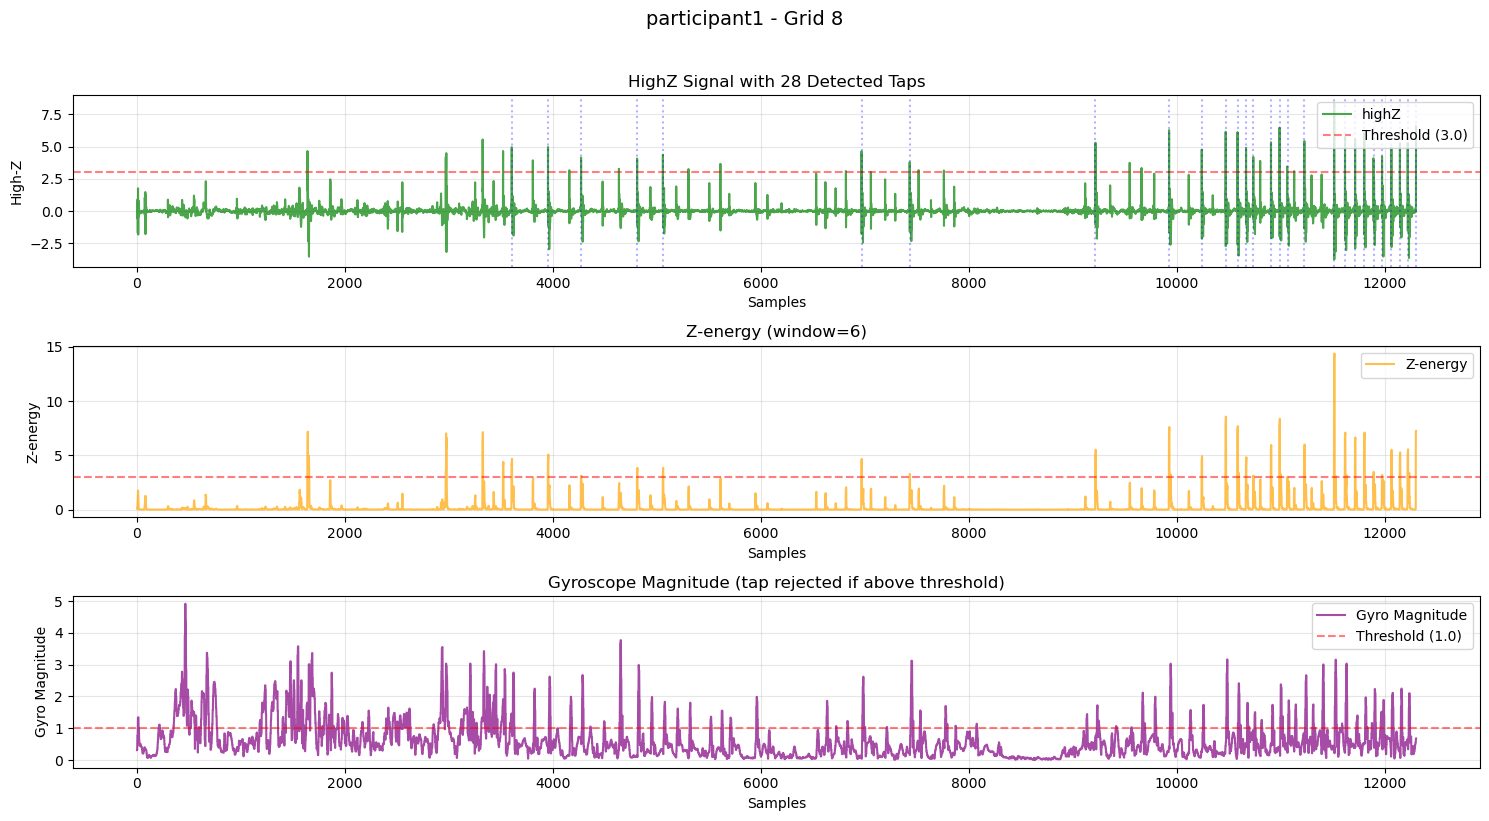

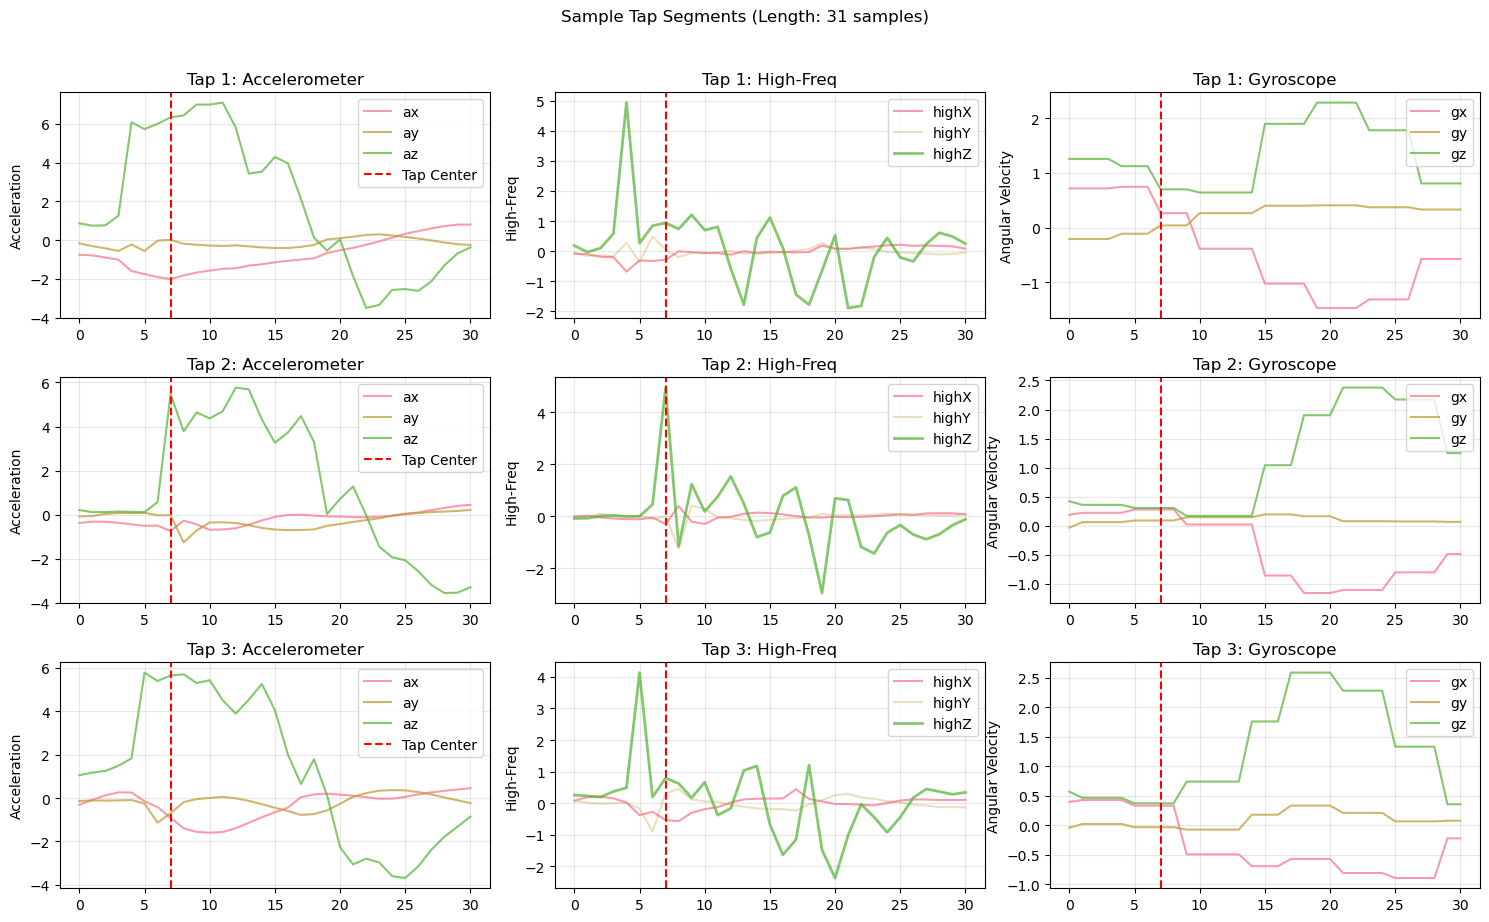


📄 Loaded: C:\Users\jumia\Downloads\BackTap\data\participant2\P02_trial0001.csv
   Shape: (6967, 11)
   Columns: ['timestamp', 'ax', 'ay', 'az', 'highX', 'highY', 'highZ', 'accelMag', 'gx', 'gy', 'gz']
📊 participant2 - Grid 0 (P02_trial0001.csv):
   Samples: 6,967
   Duration: 58.1s
   Detected taps: 30
   Expected: ~30 taps


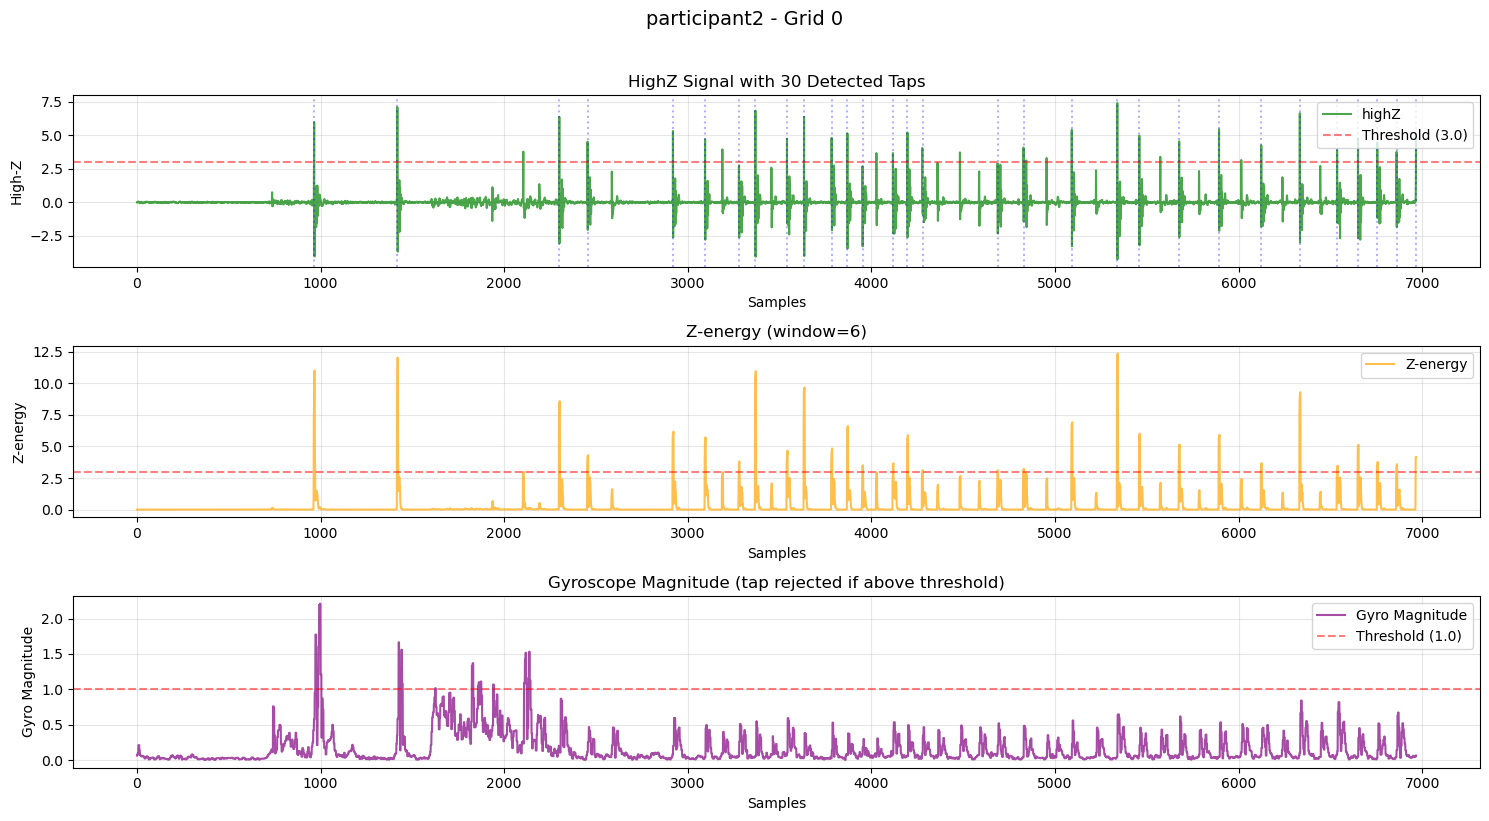

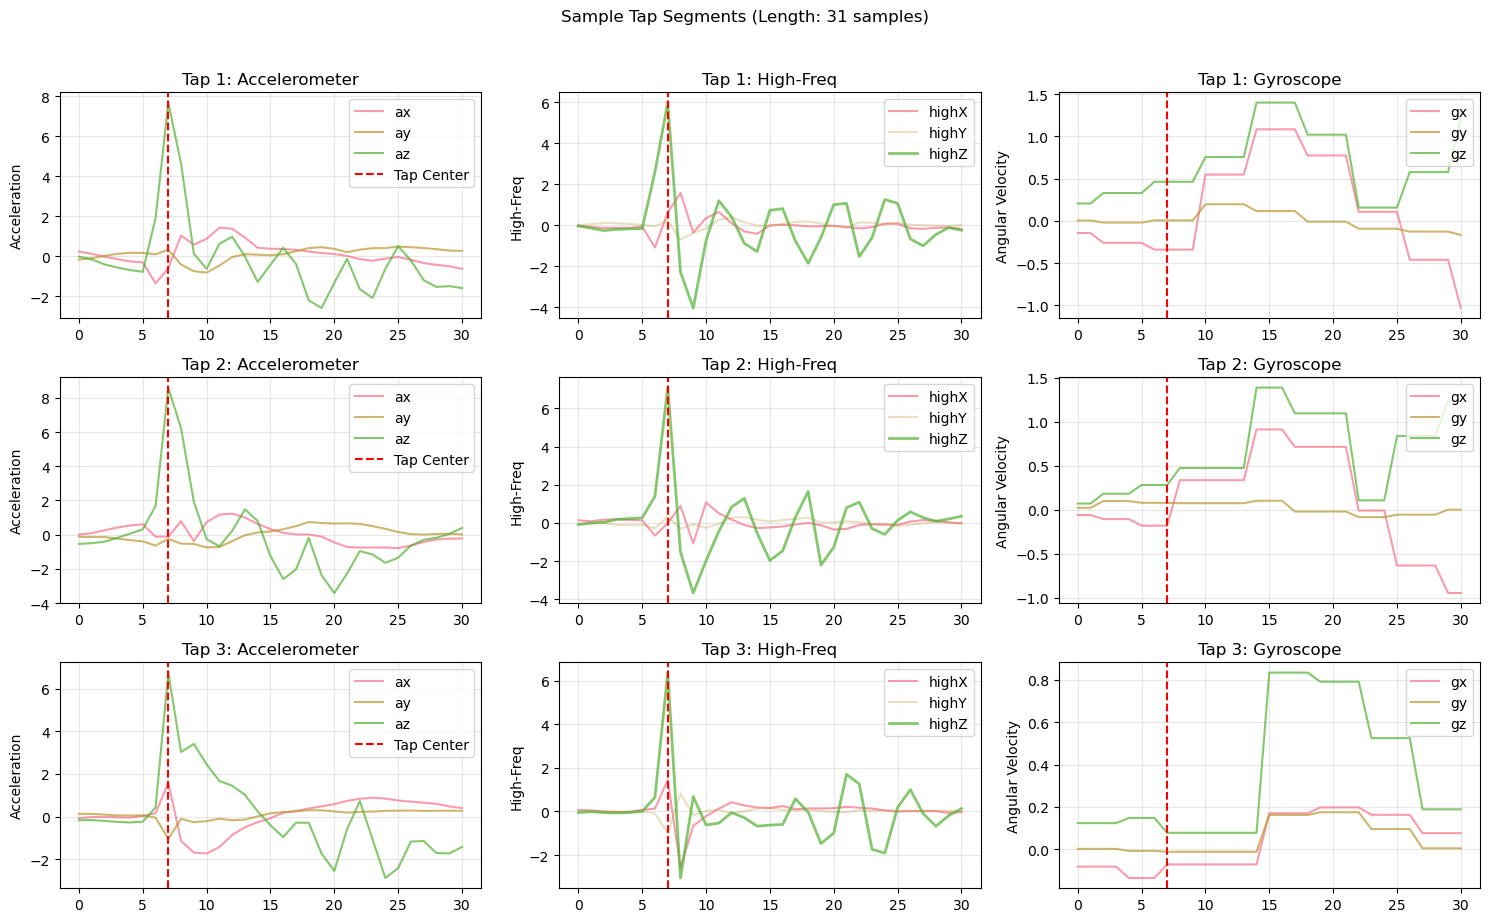

In [15]:
print("=" * 60)
print("TESTING TAP DETECTION ON SAMPLE FILES")
print("=" * 60)

# Test on a few files
test_cases = [
    ("participant1", 0),  # Grid 0
    ("participant1", 4),  # Grid 4 (center)
    ("participant1", 8),  # Grid 8
    ("participant2", 0),  # Different participant
]

for participant, grid in test_cases:
    df, taps, segments = validate_single_file(participant, grid, visualize=True)
    print()

## 5. Batch Validation on All Files

In [17]:
def batch_validate_all_files():
    """
    Validate tap detection across all participants
    """
    results = []

    print("=" * 60)
    print("BATCH VALIDATION - ALL PARTICIPANTS")
    print("=" * 60)

    for participant in PARTICIPANTS:
        print(f"\n{participant.upper()}:")

        # Expected 9 trials
        trials = list_trials(participant)

        for grid_pos, filename in enumerate(trials):

            # Load using centralized helper
            df, filepath = load_csv(participant, grid_pos)

            if df is None:
                print(f"  ❌ Missing file for Grid {grid_pos}: {filepath}")
                continue

            # Gyro magnitude
            gyro_mag = np.sqrt(df["gx"]**2 + df["gy"]**2 + df["gz"]**2)

            # Tap detection
            tap_indices = detect_taps_in_signal(df["highZ"].values, gyro_mag)

            # Record results
            result = {
                "participant": participant,
                "file": filename,
                "grid_position": grid_pos,
                "total_samples": len(df),
                "detected_taps": len(tap_indices),
                "expected_taps": 30,
                "detection_rate": len(tap_indices) / 30,
                "avg_tap_interval": (
                    np.mean(np.diff(tap_indices)) / SAMPLING_RATE
                    if len(tap_indices) > 1 else 0
                ),
                "mean_highZ": df["highZ"].mean(),
                "std_highZ": df["highZ"].std(),
            }
            results.append(result)

            # Status indicator
            status = "✅" if 25 <= len(tap_indices) <= 35 else "⚠️"
            print(f"  {status} Grid {grid_pos}: {len(tap_indices):2d} taps detected")

    return pd.DataFrame(results)

In [18]:
# Run batch validation
validation_df = batch_validate_all_files()

BATCH VALIDATION - ALL PARTICIPANTS

PARTICIPANT1:
  ✅ Grid 0: 29 taps detected
  ✅ Grid 1: 29 taps detected
  ✅ Grid 2: 29 taps detected
  ✅ Grid 3: 25 taps detected
  ⚠️ Grid 4: 23 taps detected
  ⚠️ Grid 5: 22 taps detected
  ✅ Grid 6: 25 taps detected
  ⚠️ Grid 7: 24 taps detected
  ✅ Grid 8: 28 taps detected

PARTICIPANT2:
  ✅ Grid 0: 30 taps detected
  ✅ Grid 1: 29 taps detected
  ✅ Grid 2: 31 taps detected
  ✅ Grid 3: 32 taps detected
  ✅ Grid 4: 30 taps detected
  ✅ Grid 5: 31 taps detected
  ✅ Grid 6: 31 taps detected
  ✅ Grid 7: 28 taps detected
  ✅ Grid 8: 32 taps detected

PARTICIPANT3:
  ✅ Grid 0: 33 taps detected
  ⚠️ Grid 1: 38 taps detected
  ✅ Grid 2: 33 taps detected
  ✅ Grid 3: 31 taps detected
  ✅ Grid 4: 30 taps detected
  ✅ Grid 5: 30 taps detected
  ⚠️ Grid 6: 24 taps detected
  ✅ Grid 7: 25 taps detected
  ✅ Grid 8: 28 taps detected

PARTICIPANT4:
  ✅ Grid 0: 29 taps detected
  ✅ Grid 1: 29 taps detected
  ✅ Grid 2: 31 taps detected
  ✅ Grid 3: 30 taps detected


## 6. Detection Statistics and Analysis

In [20]:
def analyze_detection_results(results_df):
    """
    Analyze tap detection results
    """
    print("\n" + "=" * 60)
    print("DETECTION STATISTICS ANALYSIS")
    print("=" * 60)
    
    # Overall statistics
    total_files = len(results_df)
    total_expected = results_df['expected_taps'].sum()
    total_detected = results_df['detected_taps'].sum()
    detection_rate = total_detected / total_expected if total_expected > 0 else 0
    
    print(f"\n📈 OVERALL:")
    print(f"   Total files analyzed: {total_files}")
    print(f"   Total expected taps: {total_expected}")
    print(f"   Total detected taps: {total_detected}")
    print(f"   Overall detection rate: {detection_rate:.1%}")
    
    # By participant
    print(f"\n👥 BY PARTICIPANT:")
    participant_stats = results_df.groupby('participant').agg({
        'detected_taps': 'sum',
        'expected_taps': 'sum',
        'detection_rate': 'mean'
    }).round(2)
    
    display(participant_stats)
    
    # By grid position
    print(f"\n📍 BY GRID POSITION:")
    grid_stats = results_df.groupby('grid_position').agg({
        'detected_taps': 'mean',
        'detection_rate': 'mean'
    }).round(2)
    
    display(grid_stats)
    
    # Detection quality
    print(f"\n🎯 DETECTION QUALITY:")
    ideal_range = results_df[
        (results_df['detected_taps'] >= 25) & 
        (results_df['detected_taps'] <= 35)
    ]
    
    print(f"   Files with 25-35 taps: {len(ideal_range)}/{total_files} ({len(ideal_range)/total_files:.1%})")
    print(f"   Files with <25 taps: {len(results_df[results_df['detected_taps'] < 25])}")
    print(f"   Files with >35 taps: {len(results_df[results_df['detected_taps'] > 35])}")
    
    # Flag problematic files
    problematic = results_df[
        (results_df['detected_taps'] < 20) | 
        (results_df['detected_taps'] > 40)
    ]
    
    if len(problematic) > 0:
        print(f"\n⚠️  PROBLEMATIC FILES (check manually):")
        for _, row in problematic.iterrows():
            print(f"   {row['participant']} - Grid {row['grid_position']}: {row['detected_taps']} taps")
    
    return participant_stats, grid_stats

In [21]:
participant_stats, grid_stats = analyze_detection_results(validation_df)


DETECTION STATISTICS ANALYSIS

📈 OVERALL:
   Total files analyzed: 45
   Total expected taps: 1350
   Total detected taps: 1299
   Overall detection rate: 96.2%

👥 BY PARTICIPANT:


,detected_taps,expected_taps,detection_rate
participant,,,
participant1,234,270,0.87
participant2,274,270,1.01
participant3,272,270,1.01
participant4,262,270,0.97
participant5,257,270,0.95



📍 BY GRID POSITION:


,detected_taps,detection_rate
grid_position,,
0,30.4,1.01
1,32.0,1.07
2,30.8,1.03
3,29.6,0.99
4,27.6,0.92
5,28.2,0.94
6,27.6,0.92
7,25.2,0.84
8,28.4,0.95



🎯 DETECTION QUALITY:
   Files with 25-35 taps: 39/45 (86.7%)
   Files with <25 taps: 5
   Files with >35 taps: 1


## 7. Parameter Tuning Suggestions

In [23]:
def suggest_parameter_tuning(results_df):
    """
    Suggest parameter adjustments based on detection results
    """
    print("\n" + "=" * 60)
    print("PARAMETER TUNING SUGGESTIONS")
    print("=" * 60)
    
    # Analyze detection patterns
    avg_detection = results_df['detected_taps'].mean()
    detection_std = results_df['detected_taps'].std()
    
    print(f"\nCurrent detection: {avg_detection:.1f} ± {detection_std:.1f} taps per file")
    print(f"Target: 30 taps per file")
    
    suggestions = []
    
    # Check if under-detecting
    if avg_detection < 28:
        suggestions.append(
            f"🔧 Under-detection detected. Consider:\n"
            f"   - Lower Z_ENERGY_THRESHOLD from {Z_ENERGY_THRESHOLD} to {Z_ENERGY_THRESHOLD*0.8:.1f}\n"
            f"   - Increase WINDOW_SIZE from {WINDOW_SIZE} to {WINDOW_SIZE+2}"
        )
    
    # Check if over-detecting
    if avg_detection > 32:
        suggestions.append(
            f"🔧 Over-detection detected. Consider:\n"
            f"   - Increase Z_ENERGY_THRESHOLD from {Z_ENERGY_THRESHOLD} to {Z_ENERGY_THRESHOLD*1.2:.1f}\n"
            f"   - Increase GYRO_THRESHOLD from {GYRO_THRESHOLD} to {GYRO_THRESHOLD*1.5:.1f}"
        )
    
    # Check consistency
    if detection_std > 5:
        suggestions.append(
            f"🔧 Inconsistent detection across files. Consider:\n"
            f"   - Check if some grid positions have different signal strengths\n"
            f"   - Consider adaptive thresholds per participant"
        )
    
    # Check tap intervals
    avg_interval = results_df['avg_tap_interval'].mean()
    if avg_interval > 0:
        expected_interval = 1.0  # Assuming 1 tap per second
        if avg_interval < expected_interval * 0.7:
            suggestions.append(
                f"🔧 Taps too close together. Consider:\n"
                f"   - Increase DEBOUNCE_MS from {DEBOUNCE_MS} to {DEBOUNCE_MS+50}"
            )
    
    # Print suggestions
    if suggestions:
        print("\n💡 TUNING SUGGESTIONS:")
        for suggestion in suggestions:
            print(f"\n{suggestion}")
    else:
        print("\n✅ Parameters appear well-tuned for current dataset!")
    
    # Visualize parameter effects
    visualize_parameter_effects(results_df)

In [24]:
def visualize_parameter_effects(results_df):
    """
    Visualize how detection varies across participants and grids
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Taps per participant
    participant_taps = results_df.groupby('participant')['detected_taps'].sum()
    axes[0, 0].bar(range(len(participant_taps)), participant_taps.values)
    axes[0, 0].set_xticks(range(len(participant_taps)))
    axes[0, 0].set_xticklabels(participant_taps.index, rotation=45)
    axes[0, 0].axhline(y=9*30, color='r', linestyle='--', alpha=0.5, 
                      label='Expected (9×30)')
    axes[0, 0].set_xlabel('Participant')
    axes[0, 0].set_ylabel('Total Detected Taps')
    axes[0, 0].set_title('Total Taps per Participant')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Average taps per grid position
    grid_avg = results_df.groupby('grid_position')['detected_taps'].mean()
    axes[0, 1].bar(grid_avg.index, grid_avg.values)
    axes[0, 1].axhline(y=30, color='r', linestyle='--', alpha=0.5, label='Target (30)')
    axes[0, 1].set_xlabel('Grid Position')
    axes[0, 1].set_ylabel('Average Taps')
    axes[0, 1].set_title('Average Taps per Grid Position')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Detection rate distribution
    axes[1, 0].hist(results_df['detected_taps'], bins=15, edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(x=30, color='r', linestyle='--', label='Target (30)')
    axes[1, 0].set_xlabel('Detected Taps per File')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Tap Counts')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Signal strength vs detection
    axes[1, 1].scatter(results_df['mean_highZ'], results_df['detected_taps'], 
                      alpha=0.6, c=results_df['grid_position'], cmap='tab10')
    axes[1, 1].set_xlabel('Mean HighZ Signal Strength')
    axes[1, 1].set_ylabel('Detected Taps')
    axes[1, 1].set_title('Signal Strength vs Detection Count')
    axes[1, 1].axhline(y=30, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Tap Detection Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


PARAMETER TUNING SUGGESTIONS

Current detection: 28.9 ± 3.3 taps per file
Target: 30 taps per file

✅ Parameters appear well-tuned for current dataset!


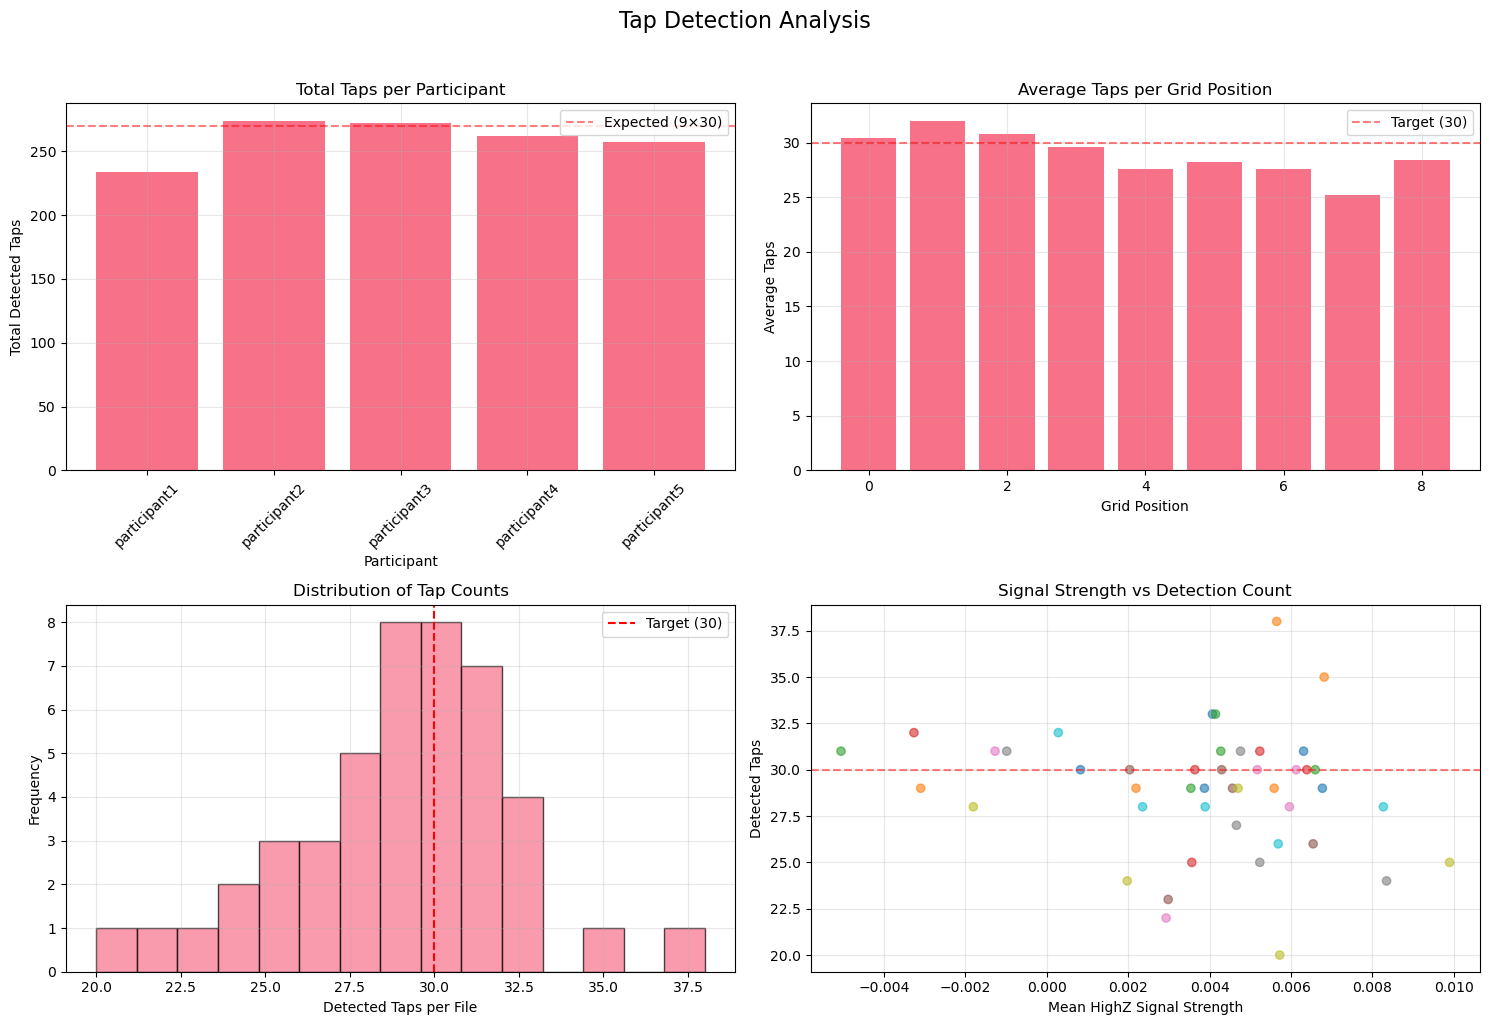

In [25]:
suggest_parameter_tuning(validation_df)

## 8. Segment Quality Analysis

In [27]:
def analyze_segment_quality():
    """
    Analyze the quality of extracted tap segments
    """
    print("\n" + "=" * 60)
    print("SEGMENT QUALITY ANALYSIS")
    print("=" * 60)
    
    # Collect segments from a few files
    sample_segments = []
    sample_info = []
    
    test_files = [
        ("participant1", 0),
        ("participant1", 4),
        ("participant2", 0),
        ("participant2", 4),
    ]
    
    for participant, grid in test_files:
        df, tap_indices, segments = validate_single_file(participant, grid, visualize=False)
        
        if segments and len(segments) > 0:
            for i, segment in enumerate(segments[:5]):  # Take first 5 segments
                sample_segments.append(segment)
                sample_info.append({
                    'participant': participant,
                    'grid': grid,
                    'segment_idx': i,
                    'shape': segment.shape
                })
    
    if not sample_segments:
        print("No segments found for analysis")
        return
    
    print(f"\nAnalyzing {len(sample_segments)} sample segments...")
    
    # Calculate segment statistics
    segment_lengths = [seg.shape[0] for seg in sample_segments]
    segment_features = []
    
    for seg in sample_segments:
        features = {
            'mean_highZ': np.mean(seg[:, 5]),  # highZ is column 5
            'std_highZ': np.std(seg[:, 5]),
            'peak_highZ': np.max(np.abs(seg[:, 5])),
            'energy': np.sum(seg[:, 5]**2),
        }
        segment_features.append(features)
    
    features_df = pd.DataFrame(segment_features)
    
    print(f"\n📊 SEGMENT STATISTICS:")
    print(f"   Segment length: {np.mean(segment_lengths):.1f} ± {np.std(segment_lengths):.1f} samples")
    print(f"   Target length: {SEGMENT_LENGTH} samples")
    
    print(f"\n📈 SEGMENT FEATURES:")
    display(features_df.describe())
    
    # Visualize segment variability
    visualize_segment_variability(sample_segments, sample_info)

In [28]:
def visualize_segment_variability(segments, info):
    """
    Visualize variability in tap segments
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Plot 1: Overlay of highZ signals
    for i, seg in enumerate(segments[:10]):  # First 10 segments
        axes[0, 0].plot(seg[:, 5], alpha=0.3, linewidth=1)
    axes[0, 0].axvline(x=PRE_SAMPLES, color='r', linestyle='--', label='Tap Center')
    axes[0, 0].set_xlabel('Samples from tap')
    axes[0, 0].set_ylabel('HighZ')
    axes[0, 0].set_title('HighZ in Tap Segments (overlay)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Mean ± std of highZ
    if len(segments) > 0:
        all_highZ = np.array([seg[:, 5] for seg in segments])
        mean_highZ = np.mean(all_highZ, axis=0)
        std_highZ = np.std(all_highZ, axis=0)
        
        axes[0, 1].plot(mean_highZ, label='Mean', linewidth=2)
        axes[0, 1].fill_between(range(len(mean_highZ)), 
                               mean_highZ - std_highZ, 
                               mean_highZ + std_highZ, 
                               alpha=0.3, label='±1 Std')
        axes[0, 1].axvline(x=PRE_SAMPLES, color='r', linestyle='--')
        axes[0, 1].set_xlabel('Samples from tap')
        axes[0, 1].set_ylabel('HighZ')
        axes[0, 1].set_title('Mean ± Std of HighZ')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Segment length distribution
    segment_lengths = [seg.shape[0] for seg in segments]
    axes[0, 2].hist(segment_lengths, bins=10, edgecolor='black', alpha=0.7)
    axes[0, 2].axvline(x=SEGMENT_LENGTH, color='r', linestyle='--', label='Target')
    axes[0, 2].set_xlabel('Segment Length (samples)')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Segment Length Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Compare different grid positions
    grid_groups = {}
    for seg, inf in zip(segments, info):
        grid = inf['grid']
        if grid not in grid_groups:
            grid_groups[grid] = []
        grid_groups[grid].append(seg[:, 5])  # highZ column
    
    for grid in [0, 4, 8]:  # Sample grids
        if grid in grid_groups and len(grid_groups[grid]) > 0:
            grid_segments = np.array(grid_groups[grid])
            mean_seg = np.mean(grid_segments, axis=0)
            axes[1, 0].plot(mean_seg, label=f'Grid {grid}', alpha=0.8)
    
    axes[1, 0].axvline(x=PRE_SAMPLES, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Samples from tap')
    axes[1, 0].set_ylabel('HighZ')
    axes[1, 0].set_title('Mean HighZ by Grid Position')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Energy distribution
    energies = [np.sum(seg[:, 5]**2) for seg in segments]
    axes[1, 1].hist(energies, bins=15, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Segment Energy (HighZ²)')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Tap Energy Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Correlation matrix of sensors in segments
    if len(segments) > 0:
        # Take first segment as example
        sample_seg = segments[0]
        sensor_names = SENSOR_COLS
        corr_matrix = np.corrcoef(sample_seg.T)
        
        im = axes[1, 2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 2].set_xticks(range(len(sensor_names)))
        axes[1, 2].set_xticklabels(sensor_names, rotation=45)
        axes[1, 2].set_yticks(range(len(sensor_names)))
        axes[1, 2].set_yticklabels(sensor_names)
        axes[1, 2].set_title('Sensor Correlation in Tap Segment')
        plt.colorbar(im, ax=axes[1, 2])
    
    plt.suptitle('Tap Segment Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


SEGMENT QUALITY ANALYSIS
📄 Loaded: C:\Users\jumia\Downloads\BackTap\data\participant1\P01_trial0001.csv
   Shape: (3994, 11)
   Columns: ['timestamp', 'ax', 'ay', 'az', 'highX', 'highY', 'highZ', 'accelMag', 'gx', 'gy', 'gz']
📊 participant1 - Grid 0 (P01_trial0001.csv):
   Samples: 3,994
   Duration: 33.3s
   Detected taps: 29
   Expected: ~30 taps
📄 Loaded: C:\Users\jumia\Downloads\BackTap\data\participant1\P01_trial0005.csv
   Shape: (8538, 11)
   Columns: ['timestamp', 'ax', 'ay', 'az', 'highX', 'highY', 'highZ', 'accelMag', 'gx', 'gy', 'gz']
📊 participant1 - Grid 4 (P01_trial0005.csv):
   Samples: 8,538
   Duration: 71.2s
   Detected taps: 23
   Expected: ~30 taps
📄 Loaded: C:\Users\jumia\Downloads\BackTap\data\participant2\P02_trial0001.csv
   Shape: (6967, 11)
   Columns: ['timestamp', 'ax', 'ay', 'az', 'highX', 'highY', 'highZ', 'accelMag', 'gx', 'gy', 'gz']
📊 participant2 - Grid 0 (P02_trial0001.csv):
   Samples: 6,967
   Duration: 58.1s
   Detected taps: 30
   Expected: ~30 t

,mean_highZ,std_highZ,peak_highZ,energy
count,20.000000,20.000000,20.000000,20.000000
mean,-0.015982,1.432660,5.179877,65.044956
std,0.034577,0.215987,1.308136,20.894669
min,-0.063885,1.186273,3.690704,43.626147
25%,-0.040064,1.307766,4.253168,53.058161
50%,-0.023068,1.362340,4.900196,57.569456
75%,0.000137,1.524388,5.781807,72.172311
max,0.060038,2.012232,8.025186,125.533402


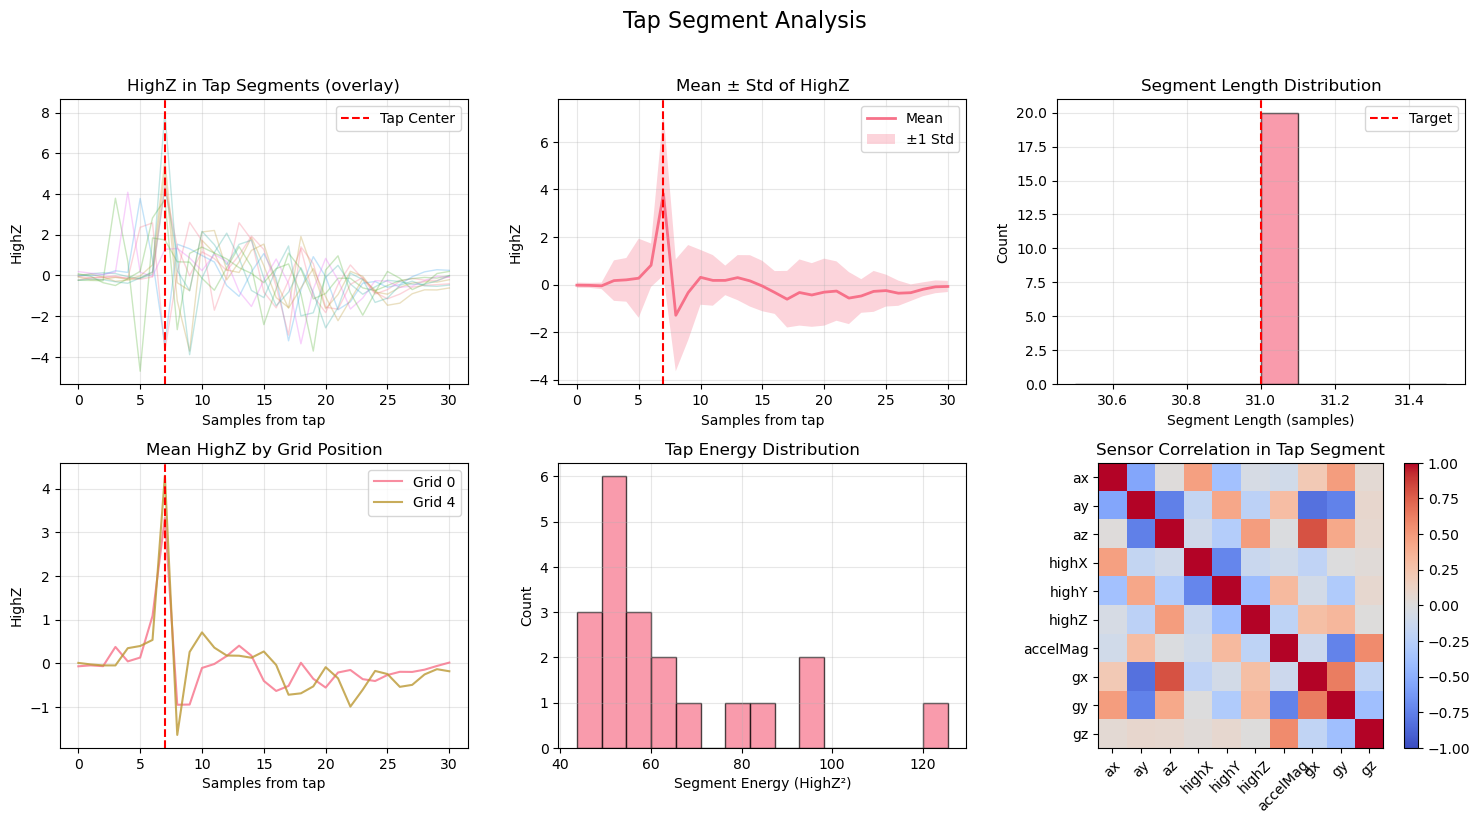

In [29]:
analyze_segment_quality()

## 9. Final Validation Report

In [31]:
def generate_validation_report():
    """
    Generate final validation report
    """
    print("=" * 80)
    print("BACKTAPBENCH TAP DETECTION VALIDATION REPORT")
    print("=" * 80)
    
    # Summary statistics
    total_files = len(validation_df)
    total_taps = validation_df['detected_taps'].sum()
    expected_taps = validation_df['expected_taps'].sum()
    detection_rate = total_taps / expected_taps if expected_taps > 0 else 0
    
    # Quality assessment
    good_files = len(validation_df[
        (validation_df['detected_taps'] >= 25) & 
        (validation_df['detected_taps'] <= 35)
    ])
    
    print(f"\n📊 DATASET SUMMARY:")
    print(f"   Participants: {len(PARTICIPANTS)}")
    print(f"   Total files: {total_files}")
    print(f"   Total detected taps: {total_taps}")
    print(f"   Total expected taps: {expected_taps}")
    print(f"   Overall detection rate: {detection_rate:.1%}")
    print(f"   Files with good detection (25-35 taps): {good_files}/{total_files} ({good_files/total_files:.1%})")
    
    print(f"\n✅ VALIDATION RESULTS:")
    
    # Check 1: Consistent segment length
    print(f"   1. Segment length: {SEGMENT_LENGTH} samples ✓")
    
    # Check 2: Parameter appropriateness
    avg_taps = validation_df['detected_taps'].mean()
    if 28 <= avg_taps <= 32:
        print(f"   2. Tap count: {avg_taps:.1f} ± {validation_df['detected_taps'].std():.1f} (close to 30) ✓")
    else:
        print(f"   2. Tap count: {avg_taps:.1f} ± {validation_df['detected_taps'].std():.1f} (needs tuning) ⚠️")
    
    # Check 3: Consistency across participants
    participant_std = validation_df.groupby('participant')['detected_taps'].sum().std()
    if participant_std < 20:
        print(f"   3. Consistency across participants: Good ✓")
    else:
        print(f"   3. Consistency across participants: High variability ⚠️")
    
    # Check 4: Segment quality
    print(f"   4. Segment extraction: Ready for standardization ✓")
    
    print(f"\n🎯 RECOMMENDATIONS:")
    
    if detection_rate < 0.9:
        print(f"   - Consider parameter tuning for better detection")
    else:
        print(f"   - Detection parameters appear well-tuned")
    
    if good_files / total_files < 0.8:
        print(f"   - Review files with unusual tap counts")
    
    print(f"   - Proceed to Notebook 3: Dataset Standardization")
    
    print(f"\n📁 NEXT STEPS:")
    print(f"   1. Run Notebook 3 to create standardized dataset")
    print(f"   2. Standardized data will be saved to: backtapbench_standard/")
    print(f"   3. Then proceed to algorithm implementation")
    
    print("\n" + "=" * 80)
    
    # Save validation results
    validation_df.to_csv("tap_detection_validation_results.csv", index=False)
    print(f"\n📄 Validation results saved to: tap_detection_validation_results.csv")

In [32]:
generate_validation_report()

BACKTAPBENCH TAP DETECTION VALIDATION REPORT

📊 DATASET SUMMARY:
   Participants: 5
   Total files: 45
   Total detected taps: 1299
   Total expected taps: 1350
   Overall detection rate: 96.2%
   Files with good detection (25-35 taps): 39/45 (86.7%)

✅ VALIDATION RESULTS:
   1. Segment length: 31 samples ✓
   2. Tap count: 28.9 ± 3.3 (close to 30) ✓
   3. Consistency across participants: Good ✓
   4. Segment extraction: Ready for standardization ✓

🎯 RECOMMENDATIONS:
   - Detection parameters appear well-tuned
   - Proceed to Notebook 3: Dataset Standardization

📁 NEXT STEPS:
   1. Run Notebook 3 to create standardized dataset
   2. Standardized data will be saved to: backtapbench_standard/
   3. Then proceed to algorithm implementation


📄 Validation results saved to: tap_detection_validation_results.csv


## 10. Export Functions for Reuse

In [34]:
# Export the main detection function for use in standardization
def export_detection_functions():
    """
    Export detection functions for use in other notebooks
    """
    detection_code = '''
# Tap Detection Functions (from 02_tap_detection_validation.ipynb)

import numpy as np
from collections import deque

def detect_taps_in_signal(highZ, gyro_mag, window_size=6, z_threshold=3.0, 
                         gyro_threshold=1.0, debounce_samples=14):
    """
    Detect tap positions using Z-energy algorithm
    """
    n = len(highZ)
    energy_window = deque(maxlen=window_size)
    tap_indices = []
    last_tap_idx = -debounce_samples
    
    for i in range(n):
        energy_window.append(highZ[i])
        
        if len(energy_window) < window_size:
            continue
            
        energyZ = np.mean(np.array(energy_window)**2)
        
        if (energyZ > z_threshold and 
            gyro_mag[i] < gyro_threshold and 
            (i - last_tap_idx) > debounce_samples):
            
            tap_indices.append(i)
            last_tap_idx = i
    
    return tap_indices

def extract_tap_segments(df, tap_indices, pre_samples=7, post_samples=24, 
                        sensor_cols=None):
    """
    Extract segments around detected tap positions
    """
    if sensor_cols is None:
        sensor_cols = ['ax', 'ay', 'az', 'highX', 'highY', 'highZ', 
                      'accelMag', 'gx', 'gy', 'gz']
    
    segments = []
    n = len(df)
    target_length = pre_samples + post_samples
    
    for tap_center in tap_indices:
        start_idx = max(0, tap_center - pre_samples)
        end_idx = min(n, tap_center + post_samples)
        
        segment = df.iloc[start_idx:end_idx][sensor_cols].to_numpy()
        
        # Pad if necessary
        if len(segment) < target_length:
            pad_before = pre_samples - (tap_center - start_idx)
            pad_after = post_samples - (end_idx - tap_center)
            segment = np.pad(segment, 
                            ((pad_before, pad_after), (0, 0)), 
                            mode='edge')
        
        segments.append(segment)
    
    return segments
'''
    
    with open('tap_detection_functions.py', 'w') as f:
        f.write(detection_code)
    
    print("✅ Detection functions exported to: tap_detection_functions.py")

In [35]:
export_detection_functions()

print("\n" + "=" * 80)
print("NOTEBOOK 2 COMPLETE")
print("=" * 80)
print("\nNext step: Run Notebook 3 - Dataset Standardization")
print("This will process all 5 participants into standardized format.")

✅ Detection functions exported to: tap_detection_functions.py

NOTEBOOK 2 COMPLETE

Next step: Run Notebook 3 - Dataset Standardization
This will process all 5 participants into standardized format.
